# debug precompute

## Load data

In [18]:
from ipywidgets import interact,IntSlider
import os 

import numpy as np
root='datasets/alg_out/'
root_ct='datasets/ct'
root_out='results'
import eval_seg
@interact
def selectData(dataset=['Task001_LiverTumor','Task002_Pancreas','Task003_Multiorgan']):
    @interact
    def fileviewer(file=sorted(os.listdir(f'{root}/{dataset}/GroundTruth'))):
        # file='train_242.nii.gz'
        gt_orig,voxelsize_orig=eval_seg.io.read_nib(f'{root}/{dataset}/GroundTruth/{file}')
        print(voxelsize_orig)
        
        ct,_=eval_seg.io.read_nib(f'{root_ct}/{dataset}/{file}'.replace('.nii.gz','_0000.nii.gz'))
        ct = gt_orig if ct is None else ct 
    
        gtmax=(gt_orig.sum(axis=2).sum(axis=1).argmax(),gt_orig.sum(axis=2).sum(axis=0).argmax(),gt_orig.sum(axis=1).sum(axis=0).argmax())      
        eval_seg.ui.ortho_slicer(ct,{'gt':gt_orig},gtmax)

            
        @interact
        def fileviewer2(typ=['CE','Dice','DiceCE','DiceFocal','DiceTopK10','TopK10']):
                pr_orig,pr_voxel_size = eval_seg.io.read_nib(f'{root}/{dataset}/{typ}/{file}')
                if (voxelsize_orig!=pr_voxel_size).any():
                    raise Error('voxel sizes are different')
                
                eval_seg.ui.ortho_slicer(ct,{typ:pr_orig},gtmax)
                only_axis_data={2:'z',-1:'All',0:'x',1:'y',2:'z'}
                @interact 
                def only_axis(only_axis={only_axis_data[d]:d for d in only_axis_data}):
                    axi,ax=only_axis,only_axis_data[only_axis]
                    if axi == -1:
                        global gt,pr,voxelsize
                        gt=gt_orig
                        pr=pr_orig
                        voxelsize=voxelsize_orig
                        print(f'dataset {dataset} ({pr.shape}) predict {typ} loaded....')
                    else:                        
                        @interact
                        def onlyMaxFrame(frame=IntSlider(gtmax[axi],min=0,max=gt_orig.shape[axi])):
                                global gt,pr,voxelsize
                                gt,voxelsize=eval_seg.geometry.slice(gt_orig,voxelsize_orig,axi,[frame])
                                pr,_=eval_seg.geometry.slice(pr_orig,voxelsize_orig,axi,[frame])
                                
                                eval_seg.ui.multi_plot_2d(
                                    ct,
                                    {'gt':gt,typ:pr},
                                    args={
                                        "imglabel": f"{dataset.split('_')[1]} {file.split('_')[1].split('.')[0]} {ax}={gtmax[axi]}",
                                        'z_titles':[gtmax[axi]],
                                        "add_backimg": 1,
                                        "clahe": 1,
                                        "crop2roi": 1,
                                        "zoom2segments": 1,
                                        "add_notzoom_img": 1,
                                        #                 'interactive':1,
                                        "show_tp_fp_fn": 1,
                                        "show": 1,
                                        "spacing": voxelsize,
                                    },
                                )

                                print(f'dataset {dataset} ({pr.shape}) predict {typ} loaded....')
            

interactive(children=(Dropdown(description='dataset', options=('Task001_LiverTumor', 'Task002_Pancreas', 'Task…

In [23]:
import eval_seg
eval_seg.reload()
# importlib.reload(eval_seg)
# importlib.reload(eval_seg.common)
# # importlib.reload(eval_seg.common.cache)
# importlib.reload(eval_seg.metrics)
# importlib.reload(eval_seg.geometry)

# importlib.reload(eval_seg.metrics.mme)

mme=eval_seg.metrics.MME(int(gt.max()+1),debug={'show_precompute':1})

from auto_profiler import Profiler
with Profiler(filterExternalLibraries=False):
    helper=mme.set_reference(gt,spacing=voxelsize)

'Time   [Hits × PerHit] Function name [Called from] [Function Location]'

Tree(nodes=(Node(name='root'),))

In [24]:
## import eval_seg
eval_seg.reload()
with Profiler(filterExternalLibraries=False):
    ev,d=mme.evaluate(pr,return_debug_data=True)

'Time   [Hits × PerHit] Function name [Called from] [Function Location]'

Tree(nodes=(Node(name='root'),))

In [ ]:
def myround(dic):
    if type(dic)!=dict:
        return round(dic,2)
    return {k:myround(dic[k]) for k in dic}
myround(ev)

In [ ]:

#f'{d[1]!s}'
# from pprint import pprint
# pprint(d[1])
eval_seg.reload()
for i in d[1].gts:
    dci=d[1].gts[i]
    # from eval_seg.metrics.MME import debug_helper



    aa={k:dci[k] for k in ['component_gt','rel_gt_comps','border_gt','component_pred','pred_in_region', 'border_pred']}
    # aa={k:dci[k] for k in ['component_gt','component_pred','border_pred','skgtn_dst_pred_out_v', 'skgtn_dst_pred_in_v']}
    aa={k:dci[k] for k in ['border_pred','skgtn_dst_pred_out_v', 'skgtn_dst_pred_in_v']}

    aa={f'com{i}(y=TP,g=FN,b=FP)':dci['component_gt']*3+dci['component_pred']*1,**aa,'skeleton':mme.helper['class'][1]['components'][1]['gt_skeleton']}
    eval_seg.ui.multi_plot_3d(aa)

print(str(dci))

<Object> dict_keys(['name', 'component_gt', 'component_pred', 'pred_comp', 'rel_gt_comps', 'rel_gts', 'pred_in_region', 'border_gt', 'border_pred', 'dst_border_gt2pred', 'dst_border_gt2pred_abs', 'gt_hd', 'gt_hd_avg', 'gt_hd95', 'pred_border_dst', 'dst_border_pred2gt', 'dst_border_pred2gt_abs', 'pred_hd', 'pred_hd_avg', 'pred_hd95', 'hd', 'hd_avg', 'hd95', 'skgtn_dst_in', 'border_pred_inside_gt', 'border_pred_outside_gt', 'skgtn_dst_pred_in', 'skgtn_dst_pred_in_v', 'skgtn_dst_out', 'skgtn_dst_pred_out', 'skgtn_dst_pred_out_v', 'skgtn_dst_pred', 'boundary_fp', 'boundary_fn', 'boundary_tp', 'volume_gt', 'volume_pred', 'volume_tp', 'volume_fn', 'volume_fp', 'volume_tp_rate', 'volume_fn_rate', 'volume_fp_rate'])
<Object> dict_keys(['name', 'component_gt', 'component_pred', 'pred_comp', 'rel_gt_comps', 'rel_gts', 'pred_in_region', 'border_gt', 'border_pred', 'dst_border_gt2pred', 'dst_border_gt2pred_abs', 'gt_hd', 'gt_hd_avg', 'gt_hd95', 'pred_border_dst', 'dst_border_pred2gt', 'dst_border_

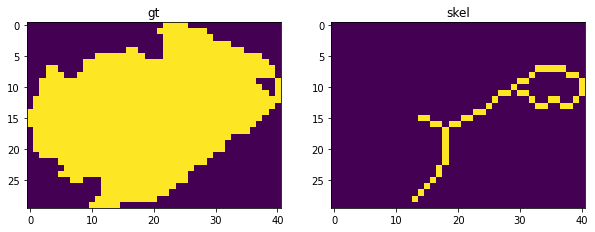

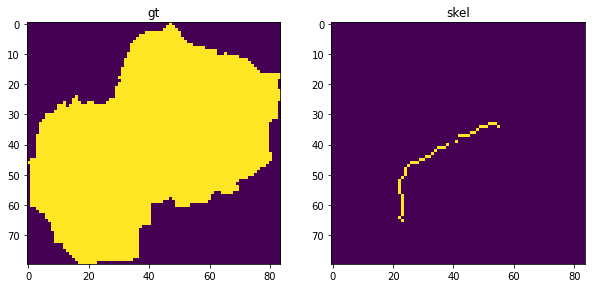

In [25]:
eval_seg.reload()
for i in d[1].gts:
    dci=d[1].gts[i]
    print(str(dci))
    
    skel=eval_seg.geometry.skeletonize(dci.component_gt, spacing=voxelsize) > 0
   
    eval_seg.ui.multi_plot_3d({'gt':dci.component_gt, 'skel':skel})



In [ ]:
asd

In [ ]:
x=mme.helper['class'][0]['components'][1]
x.keys()

In [ ]:
x=mme.helper['class'][1]['components'][1]
import eval_seg
eval_seg.reload()
mme2=eval_seg.metrics.MME(gt.max()+1,debug={'show_precompute':1})
mme2.debug_helper({a:x[a] for a in ['gt','skgt_normalized_dst','gt_skeleton','gt_skeleton_dst','gt_in_dst','gt_border']})
# mme.debug_helper(x)

In [ ]:
from eval_seg import geometry
# geometry.find_binary_boundary(x['gt'])
mme.debug_helper({'gt':mme.helper['class'][1]['gt_labels'],'gt2':gt})

In [ ]:
import eval_seg
# eval_seg.geometry.distance(x['gt_skeleton'],mode='out')
x['gt_skeleton_dst']
# x['gt_skeleton']

In [ ]:
x=mme.helper['class'][1]['components'][1]
import importlib
import eval_seg
eval_seg.reload()

mme.debug_helper({a:x[a] for a in ['gt_skeleton','gt']})

In [ ]:
eval_seg.reload()
mme2=eval_seg.metrics.MME(gt.max()+1,debug={'show_precompute':1})
helper=mme2.compress(mme.helper)

In [ ]:
mme.helper['class'][1]['components'][1]['gt_skeleton_dst_in'].max()

In [ ]:
helper=mme.helper
for x in helper['class'][0]['components'][0]:
    display(x)
    display(helper['class'][0]['components'][0][x])

In [ ]:
import compress_pickle as pickle
a=pickle.dumps(ali,compression='lz4')

In [ ]:
(helper['class'][0]['components'][0]['skgt_normalized_dst_out']>0).sum()

In [ ]:
zz=helper['class'][0]['components'][0]['skgt_normalized_dst_in'].astype(np.float32).todense()

In [ ]:
len(a)/1024/1024

In [ ]:
zz.count_nonzero ()

In [ ]:
from sparse import COO,DOK
COO(zz,fill_value=0)

In [ ]:
DOK(helper['class'][0]['gt_labels'].astype(np.uint8))